In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


spark = SparkSession.builder.getOrCreate()

In [3]:
spark.read.csv("Customer.csv", header=True).createOrReplaceTempView("customer")
spark.read.csv("DetailTransaction.csv", header=True).createOrReplaceTempView("detailTransaction")
spark.read.csv("HeaderTransaction.csv", header=True).createOrReplaceTempView("headerTransaction")
spark.read.csv("Jacket.csv", header=True).createOrReplaceTempView("jacket")
spark.read.csv("JacketType.csv", header=True).createOrReplaceTempView("jacketType")
spark.read.csv("Staff.csv", header=True).createOrReplaceTempView("staff")

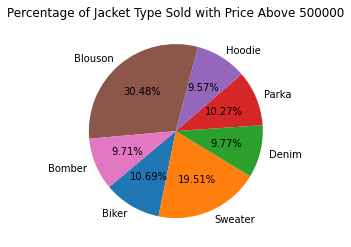

In [67]:
#a.	Show the percentage of jacket type sold in which the jacket price must be above 500000 using pie plot.

data = spark.sql("""
  select jt.jacketTypeName, sum(dt.quantity) as quantity
  from jacketType jt 
  join jacket j on jt.jacketTypeId = j.jacketTypeId
  join detailTransaction dt on dt.jacketId = j.jacketId
  where j.price > 500000
  group by jt.jacketTypeName
""").toPandas()


plt.pie(data["quantity"], labels = data["jacketTypeName"], autopct="%.2f%%", startangle=-140)
plt.title("Percentage of Jacket Type Sold with Price Above 500000")
plt.show()


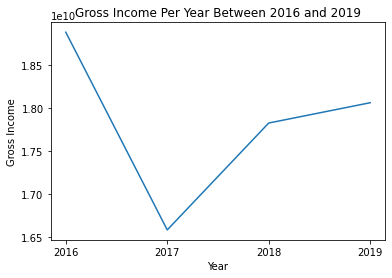

In [14]:
#b.	Show the number of gross income per year between 2016 until 2019 using line plot

data = spark.sql("""
  select sum(j.price * dt.quantity) as gross, year(ht.transactionDate) as year
  from jacket j
  join detailTransaction dt on j.jacketId = dt.jacketId
  join headerTransaction ht on ht.transactionId = dt.transactionId
  where year(ht.transactionDate) between 2016 and 2019
  group by year(ht.transactionDate)
  order by year
""").toPandas()

plt.plot(data["year"], data["gross"])
plt.title("Gross Income Per Year Between 2016 and 2019")
plt.xticks(range(2016,2020))
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.show()

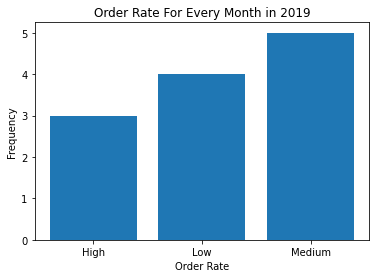

In [65]:
#c. Show the frequency of the order rate for every month in 2019 using bar plot. The order rate in a certain month is determined based on the following condition: 

data = spark.sql("""
  select orderRate, count(*) as freq
  from (
    select month(transactionDate) as month, sum(dt.quantity) as quantity,
    case
      when sum(dt.quantity) > 4000 then 'High'
      when sum(dt.quantity) between 2501 and 4000 then 'Medium'
      when sum(dt.quantity) <= 2500 then 'Low'
    end as orderRate
    from jacket j
    join detailTransaction dt on j.jacketId = dt.jacketId
    join headerTransaction ht on ht.transactionId = dt.transactionId
    where year(ht.transactionDate) = 2019
    group by month
    order by month
  )
  group by orderRate
""").toPandas()

plt.bar(data["orderRate"], data["freq"])
plt.title("Order Rate For Every Month in 2019")
plt.xlabel("Order Rate")
plt.ylabel("Frequency")
plt.show()

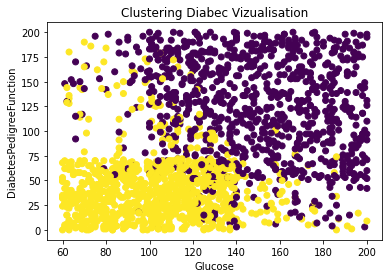

Accuracy:91.01479915433404%


In [60]:
#Clustering

testing = spark.read.csv("Test.csv", header = True, inferSchema=True)
training = spark.read.csv("Train.csv", header = True, inferSchema=True)

columns = ["Glucose", "DiabetesPedigreeFunction", "Insulin"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Glucose", "DiabetesPedigreeFunction", "Insulin", "Outcome")
training = training.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
    "Outcome", when(testing["Outcome"] == "Yes", 0)
    .otherwise(1))

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Glucose"],
    data["DiabetesPedigreeFunction"],
    c = data["prediction"]
)

plt.title("Clustering Diabec Vizualisation")
plt.xlabel("Glucose")
plt.ylabel("DiabetesPedigreeFunction")
plt.show()

count = 0
for idx, row in data.iterrows():
  if row["Outcome"] == row ["prediction"]:
    count+=1

accuracy = count/len(data) * 100
print(f'Accuracy:{accuracy}%')


